# Predicting Customer Churn in Telecom Industry

## Problem Statement:
With the rapid development of the telecommunication industry, service providers are inclined more toward expanding the subscriber base. Retaining existing customers has become a huge challenge to meet the need to survive in the competitive environment. It is stated that the cost of acquiring a new customer is far more than that of retaining the existing one. Therefore, it is imperative for the telecom industries to use advanced analytics to understand consumer behavior and predict the association of the customers as to whether or not they will leave the company.


## Summary
This analysis focused on understanding consumer behavior and predicting the association of customers as to whether or not they will leave a telecommunications company. The data contained 11 variables, with Churn being the target variable.

To begin, I conducted hypothesis-based EDA and plotted the distribution chart for the target variable. The class imbalance ratio was found to be 85.5% no churn and 14.5% churn. Additionally, I analyzed whether having more customer service calls or using more data had an impact on churn probability. It was found that customers who made 4 or more calls had churn rates above 45%, while customers in the highest quartile of data usage had a lower churn rate than those in the lower quartile.

Next, I preprocessed the data and created new features. I used a function to clip outliers between the Q1 to Q3 range for all columns and created bucketed features based on the variable distribution for CustServCalls and AccountWeeks variables. I also created a function called "treat_null_values" that dropped features with more than 60% null values and imputed columns based on median for numerical columns and mode for categorical variables.

I then built logistic regression and XGBoost algorithms using the prepared data. The logistic model had good performance in predicting cases with no churn but low performance in predicting churn. The XGBoost algorithm achieved high accuracy but had room for improvement in identifying all customers who will churn.

To address the class imbalance problem, I researched using hyperparameters and built models with class_weight and scale_pos_weight. After hyperparameter tuning, the logistic regression model with class_weight='balanced' had a significantly improved recall score of 0.73 but a decreased precision score of 0.31. The XGBoost model with the scale_pos_weight hyperparameter achieved better results than the logistic regression model and had an accuracy of 0.908, a precision of 0.77, a recall score of 0.56, and an F1 score of 0.65.

Finally, I used SMOTE to oversample and undersample data and built logistic regression and XGBoost models. The logistic regression model had an accuracy of 0.7181, a precision score of 0.3100, a recall score of 0.7029, and an F1 score of 0.4303. The XGBoost model had an accuracy of 0.91, a precision score of 0.79, a recall score of 0.56, and an F1 score of 0.65.

Overall, my analysis showed that customer service calls and data usage can be useful indicators of churn likelihood. The logistic regression and XGBoost models with hyperparameter tuning and class weight/scale pos weight showed improvements in predicting churn, with the XGBoost model achieving the best results. However, there is still room for improvement, and other machine learning algorithms may be explored in the future. Additionally, using SMOTE to oversample and undersample data did not significantly improve model performance, and more exploration may be needed in this area.





# Loading Libraries

In [1]:
############# Loading Libraries#############
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.pyplot import suptitle
from seaborn import despine
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, roc_auc_score
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.utils import shuffle
import random
from sklearn import metrics



In [2]:
########## Importing Dataset ###############

# Load the data from the provided Google Drive link
url = 'https://drive.google.com/file/d/1Q95fBkdiw4ALjP_fbyrjPOy3F_QEr5GV/view'
file_id = url.split('/')[-2]
dwn_url = 'https://drive.google.com/uc?id=' + file_id
data = pd.read_csv(dwn_url)

# Show the columns of the dataframe
print(data.columns)

Index(['Churn', 'AccountWeeks', 'ContractRenewal', 'DataPlan', 'DataUsage',
       'CustServCalls', 'DayMins', 'DayCalls', 'MonthlyCharge', 'OverageFee',
       'RoamMins'],
      dtype='object')


# Data Exploration

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Churn            3333 non-null   int64  
 1   AccountWeeks     3333 non-null   int64  
 2   ContractRenewal  3333 non-null   int64  
 3   DataPlan         3333 non-null   int64  
 4   DataUsage        3333 non-null   float64
 5   CustServCalls    3333 non-null   int64  
 6   DayMins          3333 non-null   float64
 7   DayCalls         3333 non-null   int64  
 8   MonthlyCharge    3333 non-null   float64
 9   OverageFee       3333 non-null   float64
 10  RoamMins         3333 non-null   float64
dtypes: float64(5), int64(6)
memory usage: 286.6 KB


In [5]:
data.head()

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
0,0,128,1,1,2.7,1,265.1,110,89.0,9.87,10.0
1,0,107,1,1,3.7,1,161.6,123,82.0,9.78,13.7
2,0,137,1,0,0.0,0,243.4,114,52.0,6.06,12.2
3,0,84,0,0,0.0,2,299.4,71,57.0,3.10,6.6
4,0,75,0,0,0.0,3,166.7,113,41.0,7.42,10.1


In [5]:
data.columns

Index(['Churn', 'AccountWeeks', 'ContractRenewal', 'DataPlan', 'DataUsage',
       'CustServCalls', 'DayMins', 'DayCalls', 'MonthlyCharge', 'OverageFee',
       'RoamMins'],
      dtype='object')

In [6]:
#checking for the duplicate values
any(data.duplicated())

False

In [7]:
#describing the dataset
data.describe()

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,0.144914,101.064806,0.903090,0.276628,0.816475,1.562856,179.775098,100.435644,56.305161,10.051488,10.237294
std,0.352067,39.822106,0.295879,0.447398,1.272668,1.315491,54.467389,20.069084,16.426032,2.535712,2.791840
min,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,14.000000,0.000000,0.000000
25%,0.000000,74.000000,1.000000,0.000000,0.000000,1.000000,143.700000,87.000000,45.000000,8.330000,8.500000
50%,0.000000,101.000000,1.000000,0.000000,0.000000,1.000000,179.400000,101.000000,53.500000,10.070000,10.300000
75%,0.000000,127.000000,1.000000,1.000000,1.780000,2.000000,216.400000,114.000000,66.200000,11.770000,12.100000
max,1.000000,243.000000,1.000000,1.000000,5.400000,9.000000,350.800000,165.000000,111.300000,18.190000,20.000000


In [8]:
#checking for missing values
round(100*(data.isnull().sum()/len(data.index)), 2).sort_values(ascending = False) 

Churn              0.0
AccountWeeks       0.0
ContractRenewal    0.0
DataPlan           0.0
DataUsage          0.0
CustServCalls      0.0
DayMins            0.0
DayCalls           0.0
MonthlyCharge      0.0
OverageFee         0.0
RoamMins           0.0
dtype: float64

From the above, we can see that there are no duplicates and misisng data in the dataset hence we are good to continue with the process.

# Hypothesis-based EDA: Task 1

## Plot the distribution chart for the target variable. What is the class imbalance ratio?


Class imbalance ratio: 0.17


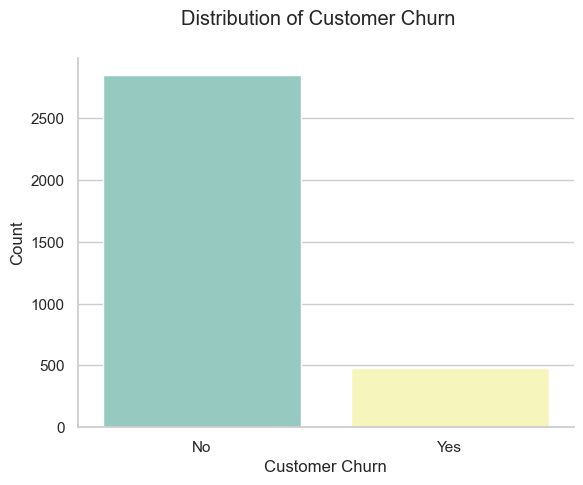

In [38]:
############Question 22*******************
# Get the counts of each value in the "Churn" column
counts = data['Churn'].value_counts()

# Calculate the class imbalance ratio
imbalance_ratio = counts[1] / counts[0]

# Plot the distribution chart
sns.set(style="whitegrid")

ax=sns.countplot(x='Churn',palette="Set3", data=data)
ax.set_xticklabels(["No","Yes"])
ax.set_ylabel("Count")
ax.set_xlabel("Customer Churn")
suptitle("Distribution of Customer Churn")
despine()

# Show the class imbalance ratio
print(f'Class imbalance ratio: {imbalance_ratio:.2f}')

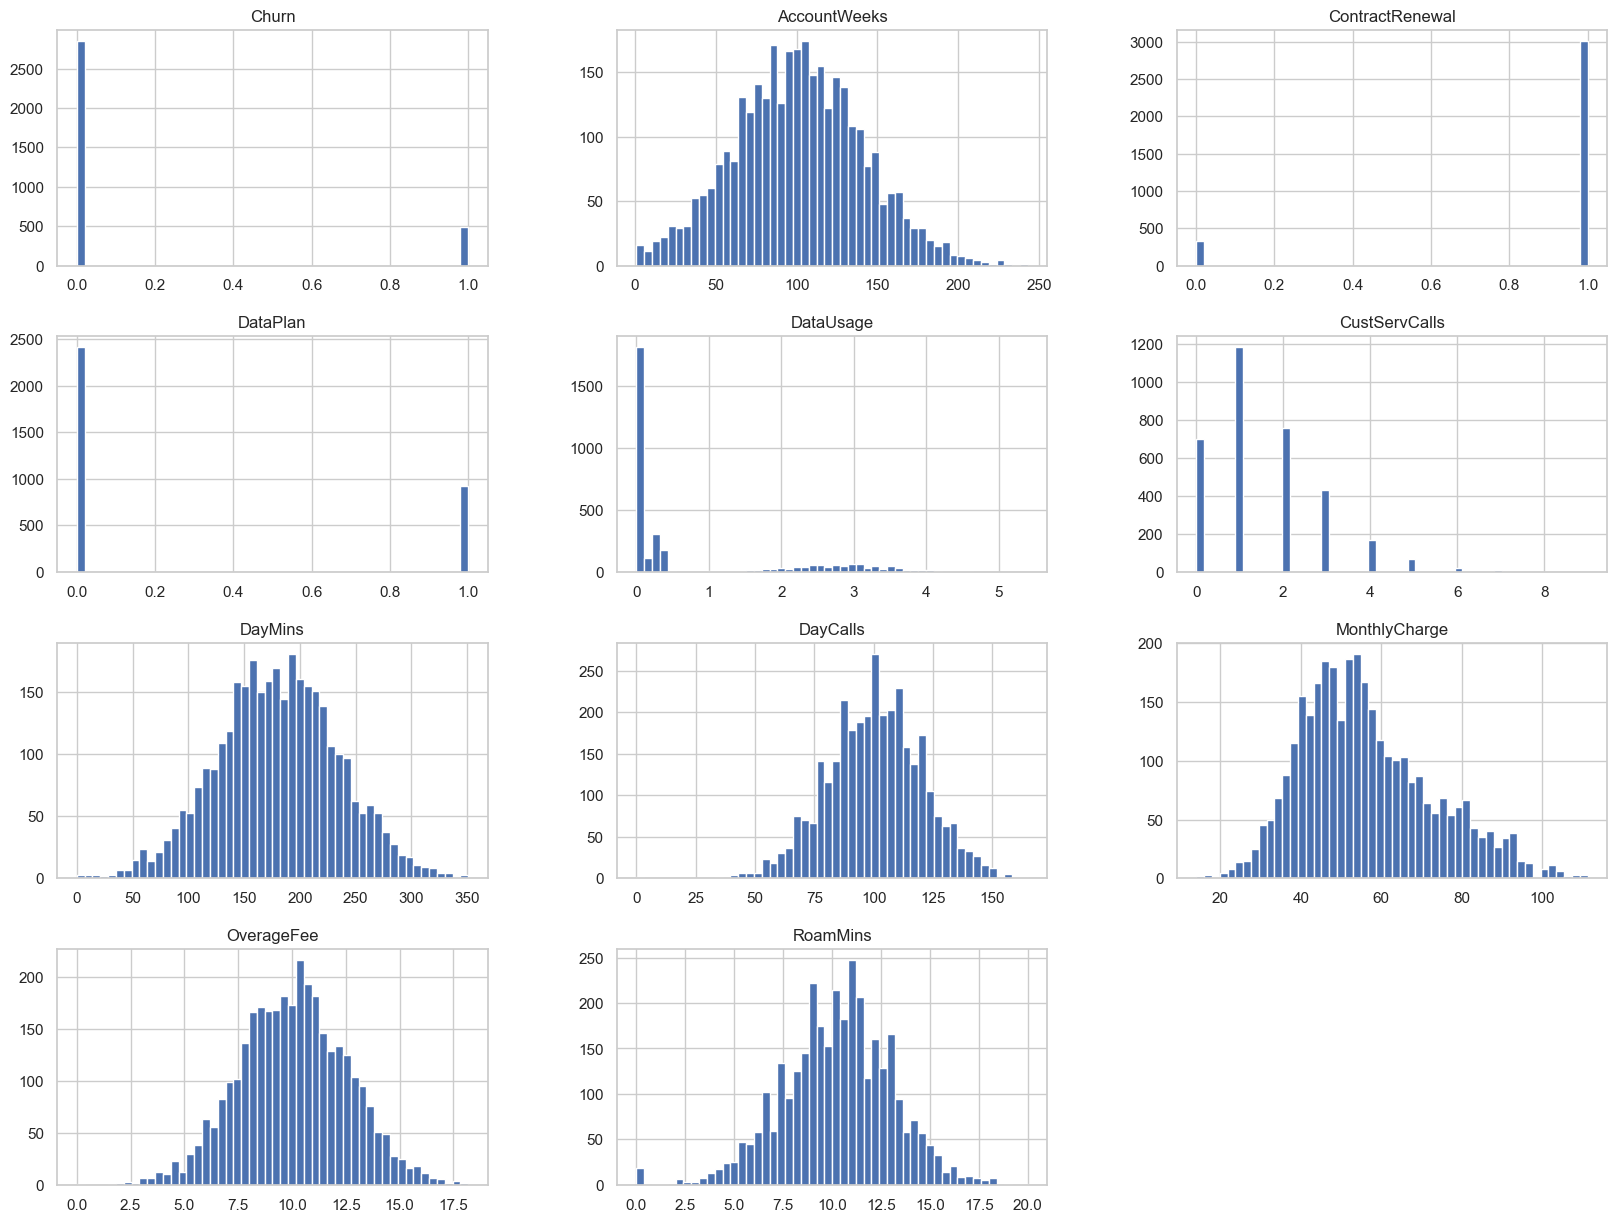

In [10]:
## Lets see the distribution of  the variables in our dataset
%matplotlib inline
data.hist(bins=50, figsize=(20,15))
plt.show()

### Examining correlation of "Churn" with other features

<AxesSubplot:>

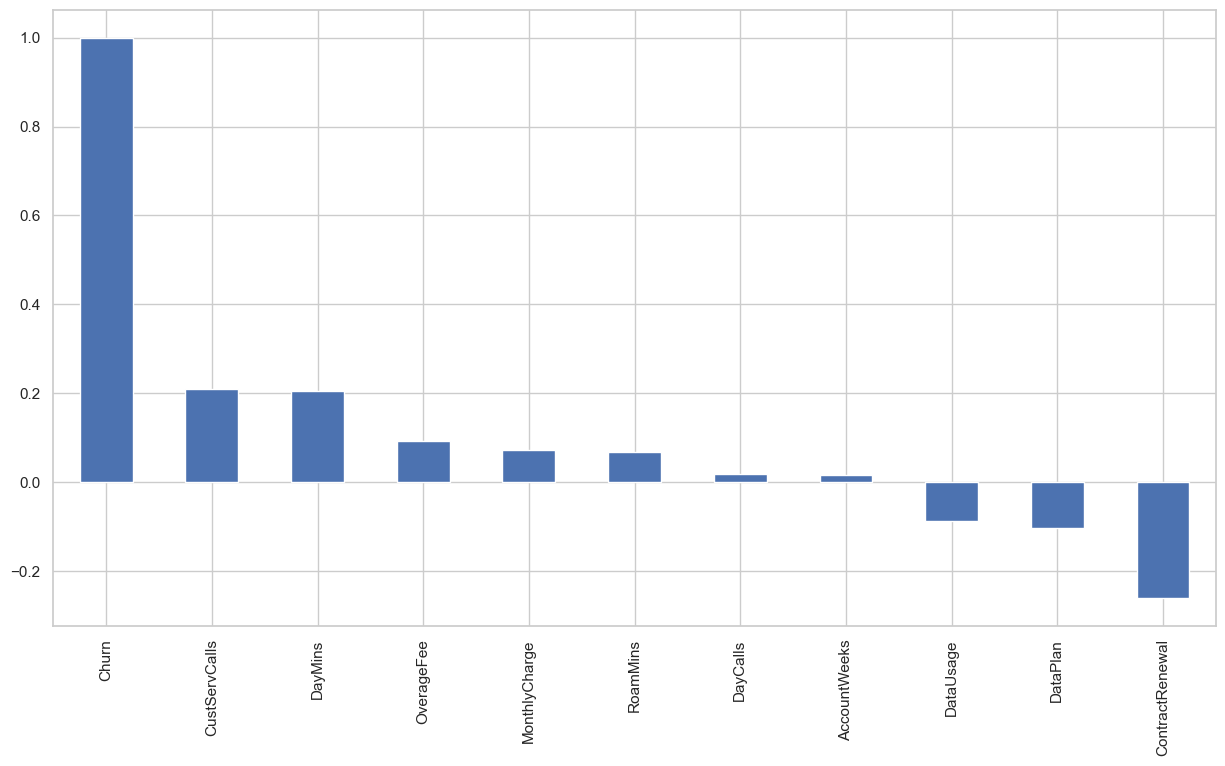

In [11]:
plt.figure(figsize=(15,8))
data.corr()['Churn'].sort_values(ascending = False).plot(kind='bar')

In [12]:
data.corr()['Churn']

Churn              1.000000
AccountWeeks       0.016541
ContractRenewal   -0.259852
DataPlan          -0.102148
DataUsage         -0.087195
CustServCalls      0.208750
DayMins            0.205151
DayCalls           0.018459
MonthlyCharge      0.072313
OverageFee         0.092812
RoamMins           0.068239
Name: Churn, dtype: float64

,Churn,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins
Churn,1.000000,0.016541,-0.259852,-0.102148,-0.087195,0.208750,0.205151,0.018459,0.072313,0.092812,0.068239
AccountWeeks,0.016541,1.000000,-0.024735,0.002918,0.014391,-0.003796,0.006216,0.038470,0.012581,-0.006749,0.009514
ContractRenewal,-0.259852,-0.024735,1.000000,-0.006006,-0.019223,0.024522,-0.049396,-0.003755,-0.047291,-0.019105,-0.045871
DataPlan,-0.102148,0.002918,-0.006006,1.000000,0.945982,-0.017824,-0.001684,-0.011086,0.737490,0.021526,-0.001318
DataUsage,-0.087195,0.014391,-0.019223,0.945982,1.000000,-0.021723,0.003176,-0.007962,0.781660,0.019637,0.162746
CustServCalls,0.208750,-0.003796,0.024522,-0.017824,-0.021723,1.000000,-0.013423,-0.018942,-0.028017,-0.012964,-0.009640
DayMins,0.205151,0.006216,-0.049396,-0.001684,0.003176,-0.013423,1.000000,0.006750,0.567968,0.007038,-0.010155
DayCalls,0.018459,0.038470,-0.003755,-0.011086,-0.007962,-0.018942,0.006750,1.000000,-0.007963,-0.021449,0.021565
MonthlyCharge,0.072313,0.012581,-0.047291,0.737490,0.781660,-0.028017,0.567968,-0.007963,1.000000,0.281766,0.117433
OverageFee,0.092812,-0.006749,-0.019105,0.021526,0.019637,-0.012964,0.007038,-0.021449,0.281766,1.000000,-0.011023


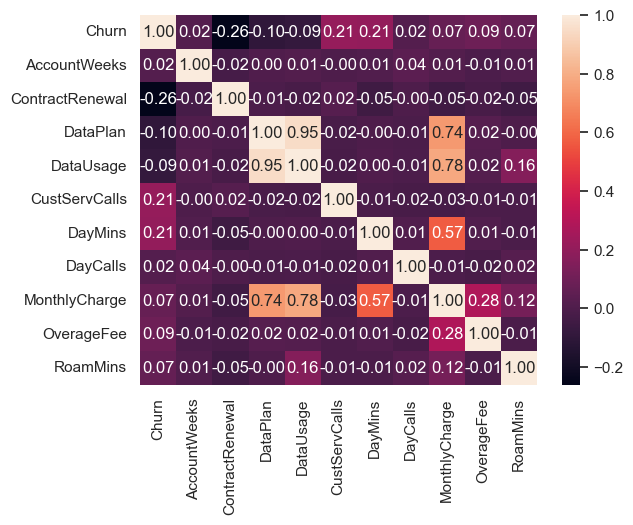

In [13]:
sns.heatmap(data.corr(), annot=True, fmt='.2f');
data.corr()

 we can see that some variables are positively correlated with Churn, such as CustServCalls, DayMins, MonthlyCharge, OverageFee, and RoamMins. This suggests that customers who have more customer service calls, higher daily minutes usage, higher monthly charges, higher overage fees, and higher roaming minutes may be more likely to churn.

On the other hand, some variables are negatively correlated with Churn, such as ContractRenewal, DataPlan, and DataUsage. This suggests that customers who have renewed their contract, have a data plan, and use more data may be less likely to churn.

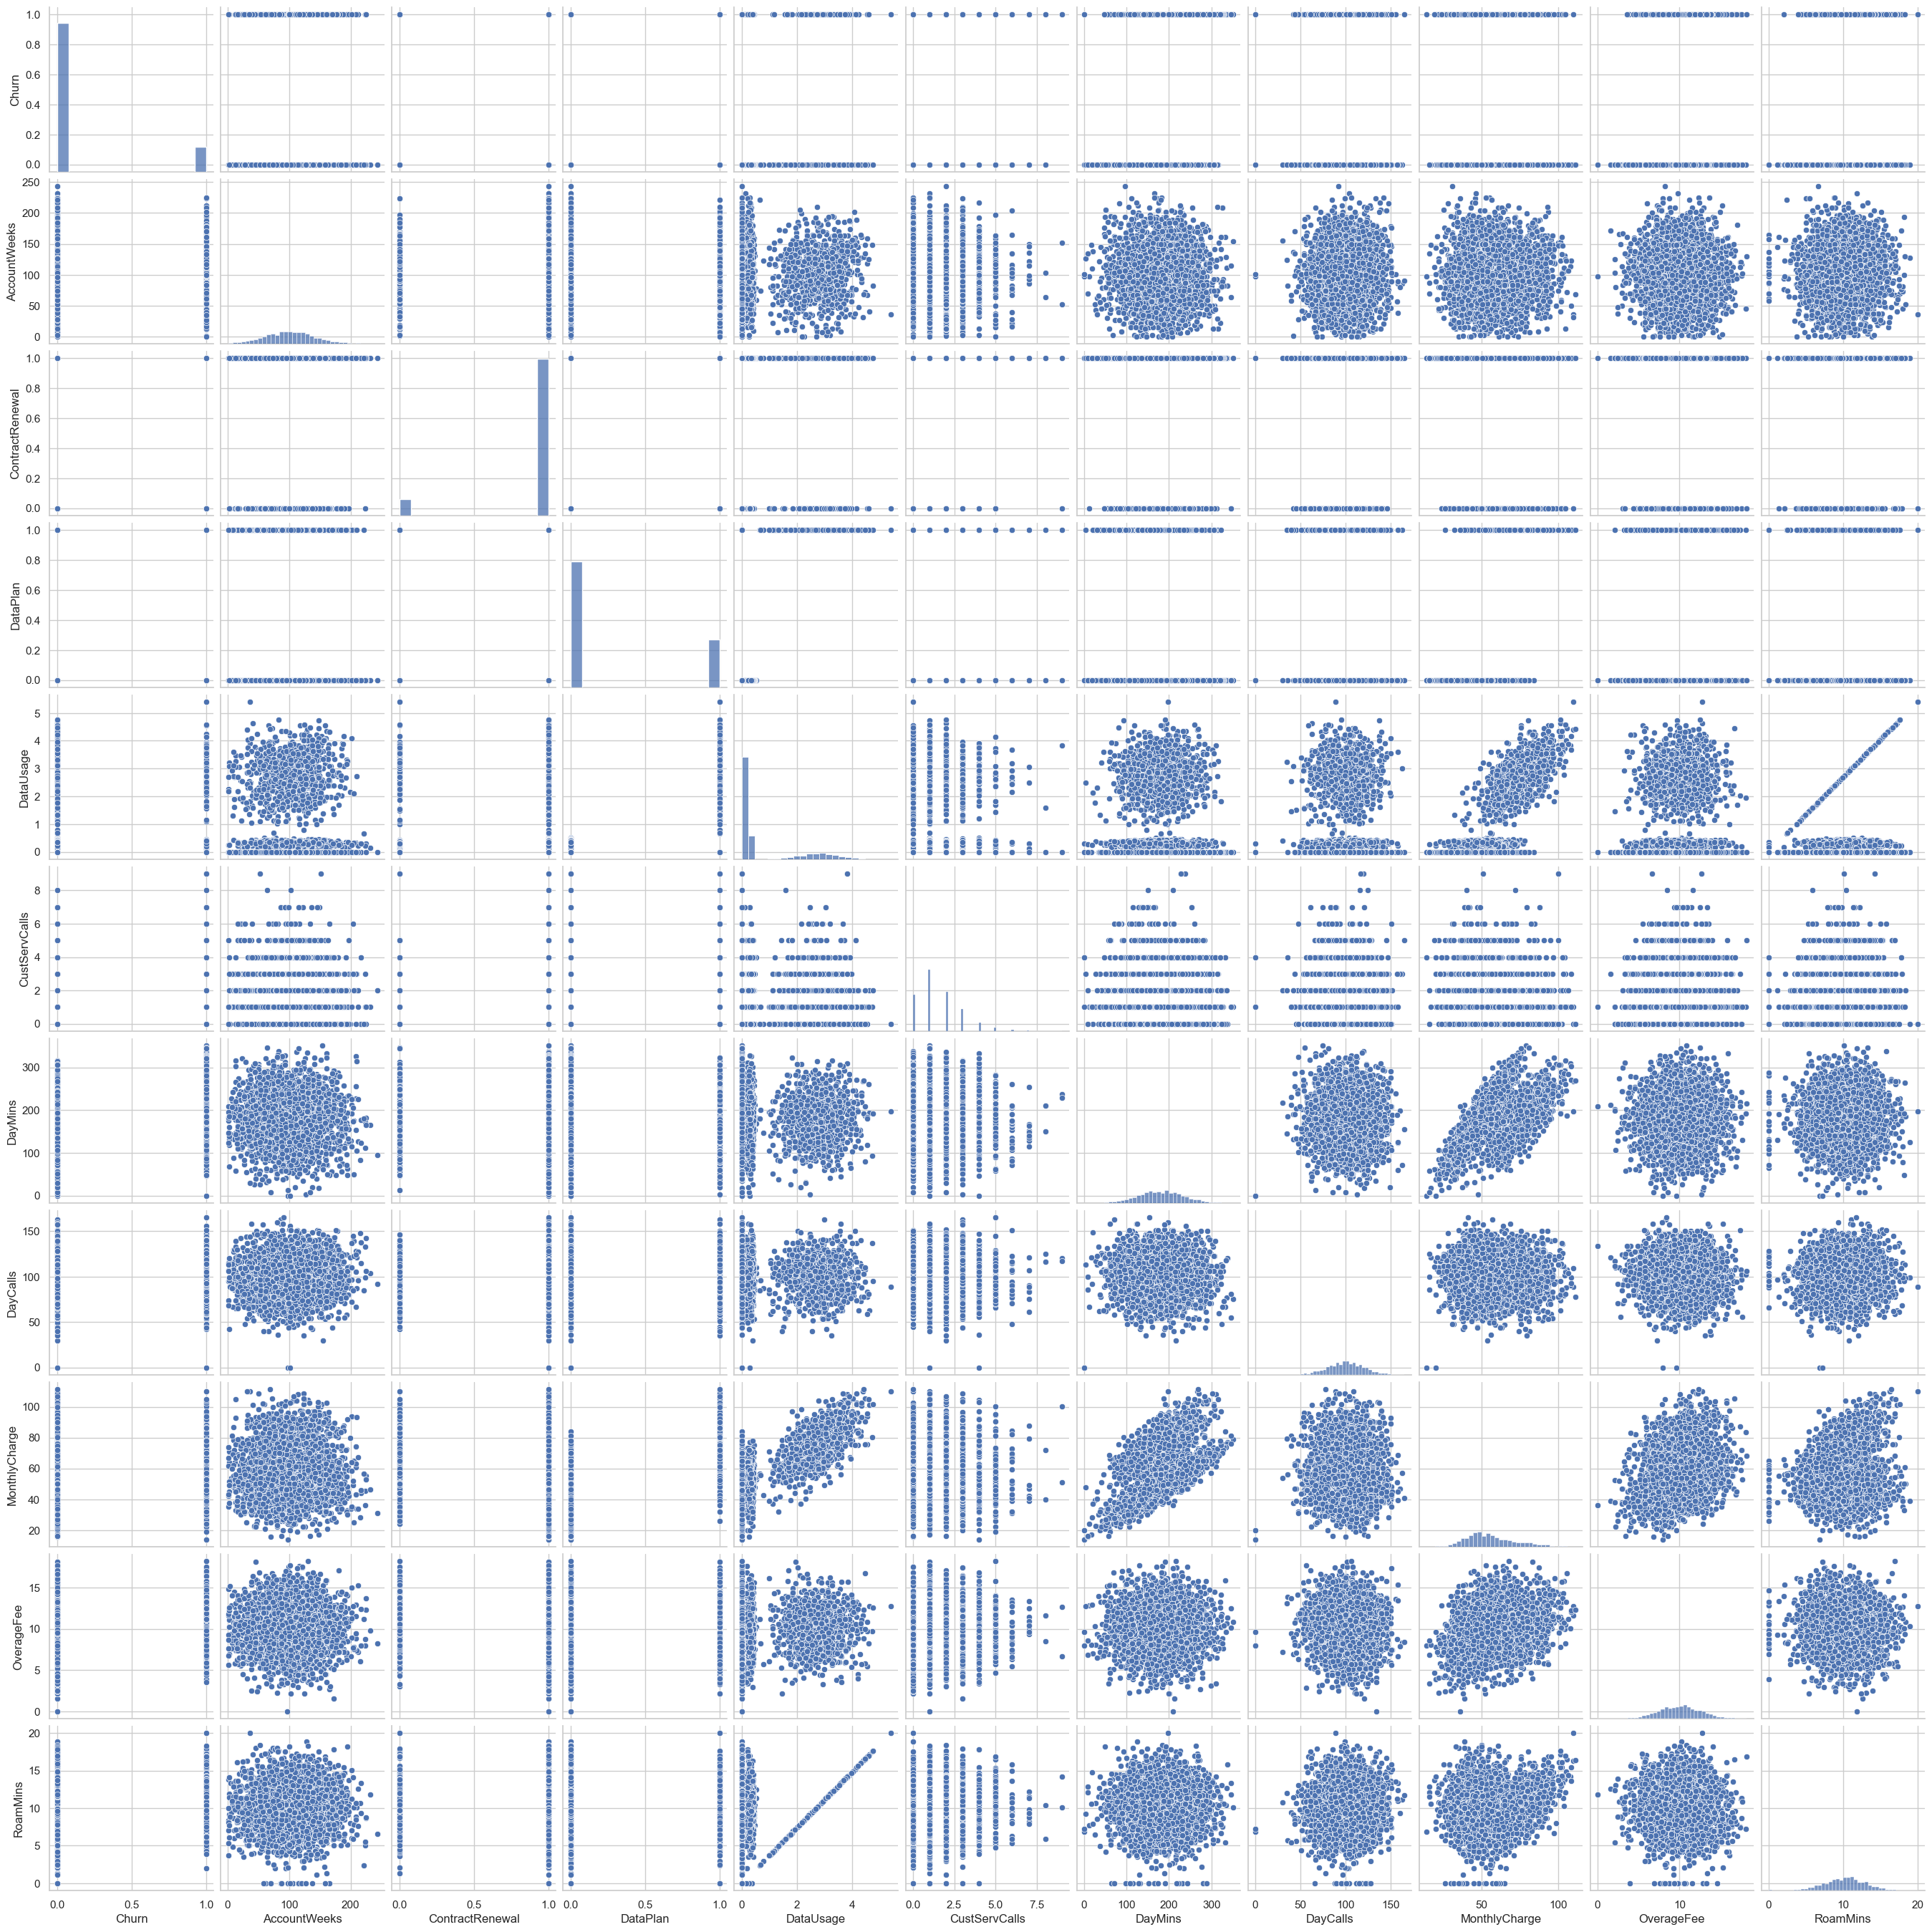

In [14]:
sns.pairplot(data);

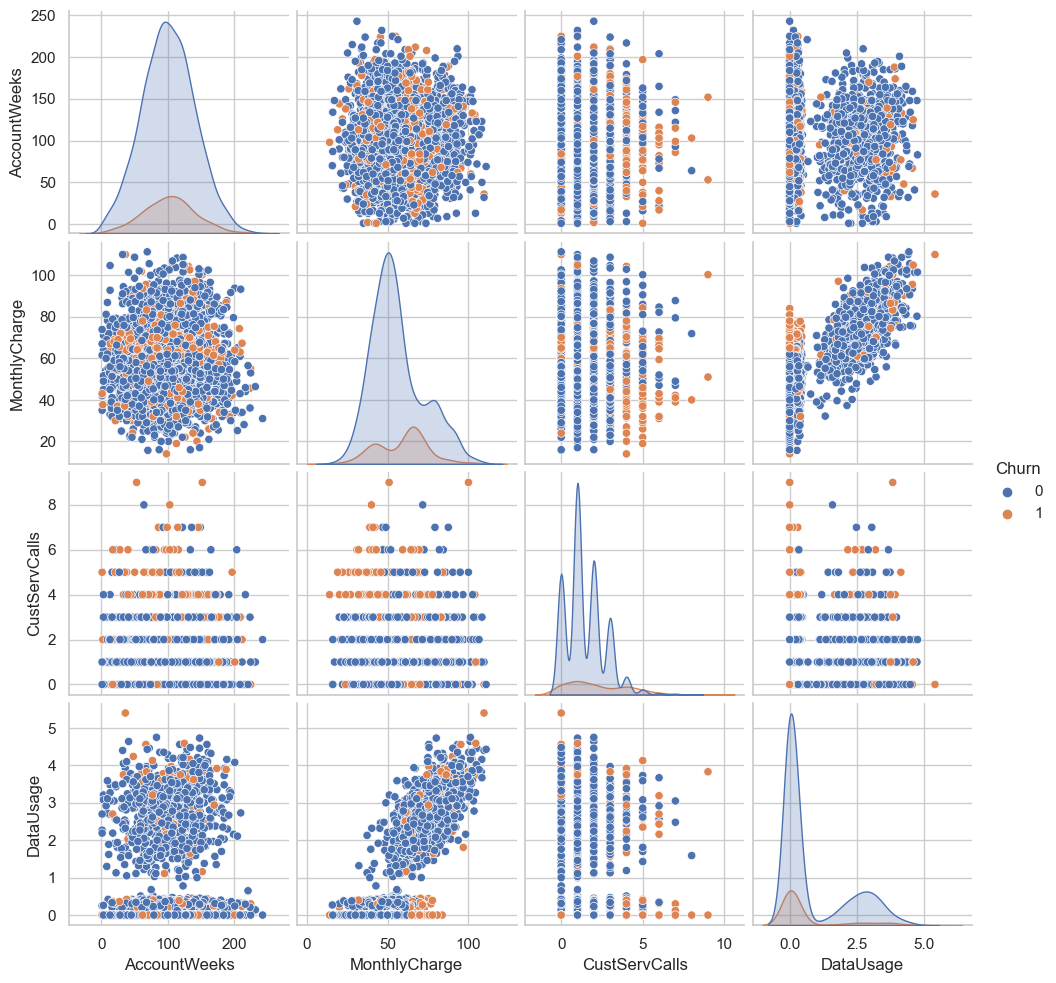

In [15]:
sns.pairplot(data[['AccountWeeks', 'MonthlyCharge', 'CustServCalls', 'DataUsage', 'Churn']], hue='Churn');

## Does having more customer service calls to increase the churn probability? 

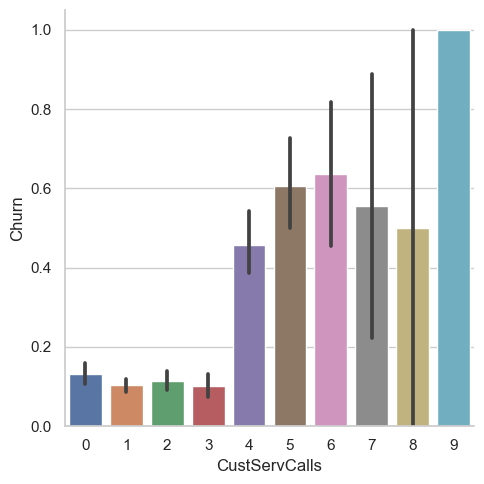

In [10]:
# Plot the relationship between customer service calls and churn
sns.catplot(x='CustServCalls', y='Churn', data=data, kind='bar')

CustServCalls
0    0.131994
1    0.103302
2    0.114625
3    0.102564
4    0.457831
5    0.606061
6    0.636364
7    0.555556
8    0.500000
9    1.000000
Name: Churn, dtype: float64


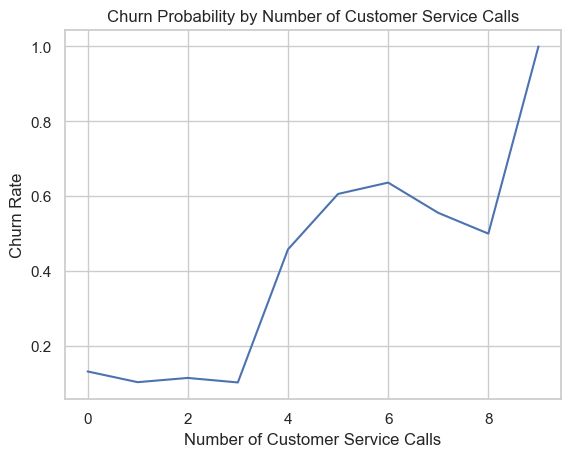

In [17]:
# Calculate the churn rate for each number of customer service calls
churn_rate = data.groupby('CustServCalls')['Churn'].mean()

# Print the churn rate for each number of customer service calls
print(churn_rate)

# Plot the churn rate by number of customer service calls
sns.lineplot(x=churn_rate.index, y=churn_rate.values)
plt.title('Churn Probability by Number of Customer Service Calls')
# Set the axis labels
plt.xlabel('Number of Customer Service Calls')
plt.ylabel('Churn Rate')

# Show the plot
plt.show()

It appears that customers who made 4 or more calls had churn rates above 45%. On the other hand, customers who made fewer calls had lower churn rates, with customers who made no calls having a churn rate of around 13%.

Therefore, it seems that the number of customer service calls made by customers can be a useful indicator of their likelihood to churn, with higher numbers of calls being associated with higher churn rates.







## If a customer uses more data, does that impact churn?

data_usage_quartile
(-0.001, 1.78]    0.164203
(1.78, 5.4]       0.086747
Name: Churn, dtype: float64


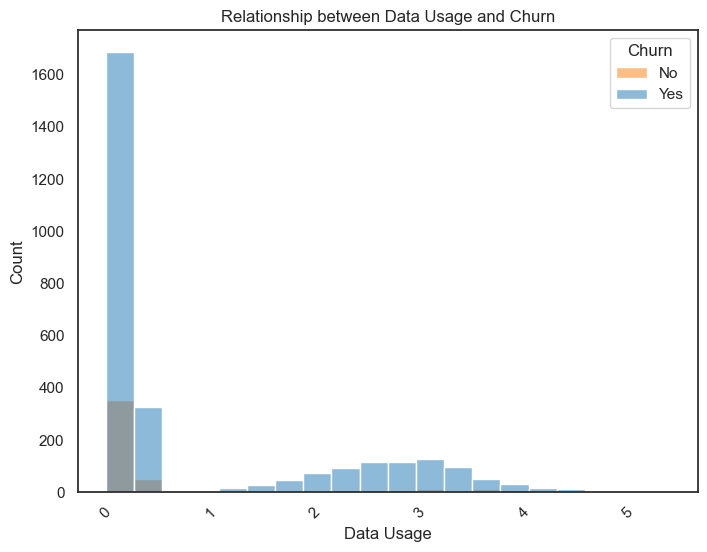

In [18]:
# Plot the relationship between data usage and churn

# Set the plot style and color palette
sns.set_palette(['#1f77b4', '#ff7f0e'])
sns.set_style('white')

# Create the figure and axes
fig, ax = plt.subplots(figsize=(8, 6))

# Plot the histogram
sns.histplot(x='DataUsage', hue='Churn', data=data, bins=20, ax=ax)

# Customize the plot
plt.xlabel('Data Usage')
plt.ylabel('Count')
plt.title('Relationship between Data Usage and Churn')
plt.legend(title='Churn', labels=['No', 'Yes'])
plt.xticks(rotation=45)

# Calculate the churn rate for each quartile of data usage
data['data_usage_quartile'] = pd.qcut(data['DataUsage'], 4, duplicates='drop')
churn_rate = data.groupby('data_usage_quartile')['Churn'].mean()

# Print the churn rate for each quartile of data usage
print(churn_rate)

This chart shows that customers in the highest quartile of data usage (between 1.78 and 5.4) have a lower churn rate than those in the lower quartile (between -0.001 and 1.78). This suggests that customers who use more data are less likely to churn, which could have implications for how the company targets its marketing efforts or offers promotions to its customers.

# Preprocess and create new features: Task 2

## Create a function to clip outliers between Q1 to Q3 range for all columns


In [11]:
def clip_outliers(data, exclude_column):
    """
    Clip outliers between Q1 to Q3 range for numerical columns in the input DataFrame,
    except for a specified column which will be excluded.
    Categorical columns are excluded from clipping.
    
    Args:
    data (pandas.DataFrame): Input DataFrame with numerical and categorical columns
    exclude_column (str): Name of column to exclude from clipping
    
    Returns:
    pandas.DataFrame: Clipped DataFrame with numerical outliers replaced by Q1 or Q3 value
    """
    num_data = data.select_dtypes(include=['int64', 'float64'])
    cat_data = data.select_dtypes(include=['category'])
    
    # Exclude specified column from clipping
    if exclude_column in num_data.columns:
        num_data_no_exclude = num_data.drop(columns=[exclude_column])
    else:
        num_data_no_exclude = num_data
        
    Q1 = num_data_no_exclude.quantile(0.25)
    Q3 = num_data_no_exclude.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Apply clipping to numerical columns, except for excluded column
    clipped_data_no_exclude = num_data_no_exclude.clip(lower=lower_bound, upper=upper_bound, axis=1)
    
    # Merge clipped numerical data with categorical data
    if exclude_column in num_data.columns:
        clipped_data = pd.concat([clipped_data_no_exclude, data[exclude_column], cat_data], axis=1)
    else:
        clipped_data = pd.concat([clipped_data_no_exclude, cat_data], axis=1)
    
    return clipped_data




In [12]:
clipped_data = clip_outliers(data, exclude_column='Churn')


In [21]:
clipped_data['Churn'].value_counts()

0    2850
1     483
Name: Churn, dtype: int64

## Create bucketed features based on the variable distribution for CustServCalls, AccountWeeks variables

We use the cut() function to create buckets for CustServCalls and AccountWeeks.

For CustServCalls, we create 4 buckets (bins=4) and label them as 'Low', 'Medium', 'High', and 'Very High'. The cut() function automatically calculates the bucket boundaries based on the variable distribution.

For AccountWeeks, we create 5 buckets (bins=5) and label them as 'Very Low', 'Low', 'Medium', 'High', and 'Very High'.

In [13]:
# Create 4 buckets for CustServCalls based on the variable distribution
clipped_data['CustServCalls_Bucket'] = pd.cut(clipped_data['CustServCalls'], bins=4, labels=['Low', 'Medium', 'High', 'Very High'])

# Create 5 buckets for AccountWeeks based on the variable distribution
clipped_data['AccountWeeks_Bucket'] = pd.cut(clipped_data['AccountWeeks'], bins=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'])

In [23]:
clipped_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   AccountWeeks          3333 non-null   float64 
 1   ContractRenewal       3333 non-null   int64   
 2   DataPlan              3333 non-null   int64   
 3   DataUsage             3333 non-null   float64 
 4   CustServCalls         3333 non-null   float64 
 5   DayMins               3333 non-null   float64 
 6   DayCalls              3333 non-null   float64 
 7   MonthlyCharge         3333 non-null   float64 
 8   OverageFee            3333 non-null   float64 
 9   RoamMins              3333 non-null   float64 
 10  Churn                 3333 non-null   int64   
 11  data_usage_quartile   3333 non-null   category
 12  CustServCalls_Bucket  3333 non-null   category
 13  AccountWeeks_Bucket   3333 non-null   category
dtypes: category(3), float64(8), int64(3)
memory usage: 296.9

# Create a function named “treat_null_values” that takes in the dataframe and does the following: Task 3

In [14]:
def treat_null_values(df):
    """
    This function takes in a pandas dataframe and drops features that have
    more than >= 60% null values, and imputes missing values with the median
    for numerical columns and mode for categorical columns.
    
    Parameters:
    -----------
    df : pandas dataframe
        The dataframe to be processed
    
    Returns:
    --------
    pandas dataframe
        The processed dataframe with null values treated.
    """
    # Calculate the percentage of null values in each column
    null_percents = (df.isnull().sum() / len(df)) * 100
    
    # Drop columns with more than 60% null values
    drop_columns = null_percents[null_percents >= 60].index
    df.drop(drop_columns, axis=1, inplace=True)
    
    # Impute missing values
    for column in df.columns:
        if df[column].dtype == 'object':
            # For categorical columns, impute with mode
            df[column].fillna(df[column].mode()[0], inplace=True)
        elif pd.api.types.is_numeric_dtype(df[column].dtype):
            # For numerical columns, impute with median
            df[column].fillna(df[column].median(), inplace=True)
    
    return df


In [15]:
df=treat_null_values(clipped_data)
df.head()

,AccountWeeks,ContractRenewal,DataPlan,DataUsage,CustServCalls,DayMins,DayCalls,MonthlyCharge,OverageFee,RoamMins,Churn,CustServCalls_Bucket,AccountWeeks_Bucket
0,128.0,1,1,2.7,1.0,265.1,110.0,89.0,9.87,10.0,0,Medium,High
1,107.0,1,1,3.7,1.0,161.6,123.0,82.0,9.78,13.7,0,Medium,Medium
2,137.0,1,0,0.0,0.0,243.4,114.0,52.0,6.06,12.2,0,Low,High
3,84.0,1,0,0.0,2.0,299.4,71.0,57.0,3.17,6.6,0,High,Medium
4,75.0,1,0,0.0,3.0,166.7,113.0,41.0,7.42,10.1,0,Very High,Low


### Logistic Regression 

In [29]:
# Convert categorical variables into dummy variables
clipped_data = pd.get_dummies(df, columns=['CustServCalls_Bucket', 'AccountWeeks_Bucket'], drop_first=True)

# Split the data into training and testing sets
X = clipped_data.drop(['Churn'], axis=1)
y = clipped_data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Create and fit the logistic regression model
lr_model = LogisticRegression()
lr_model.fit(X_train, y_train)


# Make predictions on the test set
y_pred = lr_model.predict(X_test)

# Evaluate the performance of the model
print('Accuracy:', accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))



Accuracy: 0.856
              precision    recall  f1-score   support

           0       0.86      0.99      0.92       857
           1       0.44      0.03      0.05       143

    accuracy                           0.86      1000
   macro avg       0.65      0.51      0.49      1000
weighted avg       0.80      0.86      0.80      1000



The classification report provides a summary of the precision, recall, and F1-score for each class (0 and 1) as well as the overall performance of the model.

From the accuracy score of 0.856, we can see that the model correctly predicted the churn status for about 86% of the observations in the test set.

Looking at the precision scores, we can see that the precision for class 0 (no churn) is 0.86, while the precision for class 1 (churn) is 0.44. This suggests that the model is better at predicting the cases where there is no churn (true negatives) than predicting cases where there is churn (true positives).

The recall scores show that the recall for class 0 is 0.99, which means that the model is very good at identifying cases where there is no churn (i.e., it correctly identifies almost all true negatives). However, the recall for class 1 is only 0.03, which means that the model is not good at identifying cases where there is churn (i.e., it correctly identifies very few true positives).

Finally, the F1-score takes both precision and recall into account and provides a measure of overall model performance. We can see that the F1-score for class 0 is 0.92, which is relatively high, while the F1-score for class 1 is only 0.05, indicating that the model has low performance in predicting churn.

Our logistic model has good performance in predicting the cases where there is no churn but has low performance in predicting churn. This suggests that the model may need to be improved or adjusted to better predict cases where there is churn.

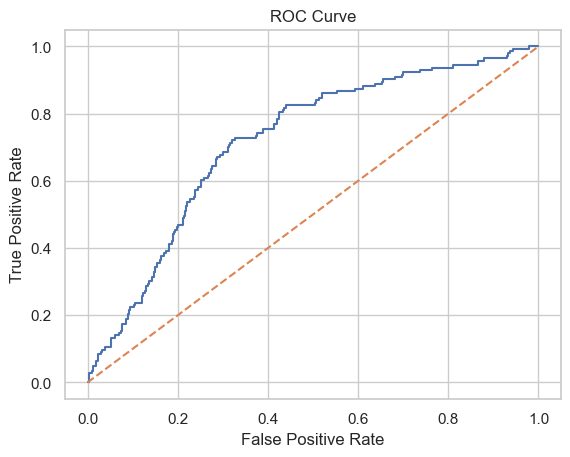

AUC: 0.7179051986519899


In [33]:

# Calculate the predicted probabilities for the test set
y_pred_proba = lr_model.predict_proba(X_test)[:,1]

# Calculate the false positive rate and true positive rate at different thresholds
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# Plot the ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

# Calculate the area under the ROC curve (AUC)
print('AUC:', roc_auc_score(y_test, y_pred_proba))

The AUC (Area Under the Curve) value of 0.7179 suggests that the logistic regression model has a fair ability to distinguish between positive and negative cases (i.e., churn and non-churn cases) in the test set.

The AUC value ranges between 0 and 1, where 0.5 represents a random guess and 1.0 represents a perfect model. In this case, the AUC value of 0.7179 indicates that the model performs better than random guessing, but there is still room for improvement.

Therefore, while the model's performance is not optimal, it still has some predictive power in differentiating between churn and non-churn cases.

### XGboost Algorithm

In [31]:
import xgboost as xgb

# Create XGBoost classifier
xgb_clf = xgb.XGBClassifier()

# Fit classifier to training data
xgb_clf.fit(X_train, y_train)


[09:27:03] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=12,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

[09:27:06] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.919
Precision: 0.810
Recall: 0.566
F1-Score: 0.667


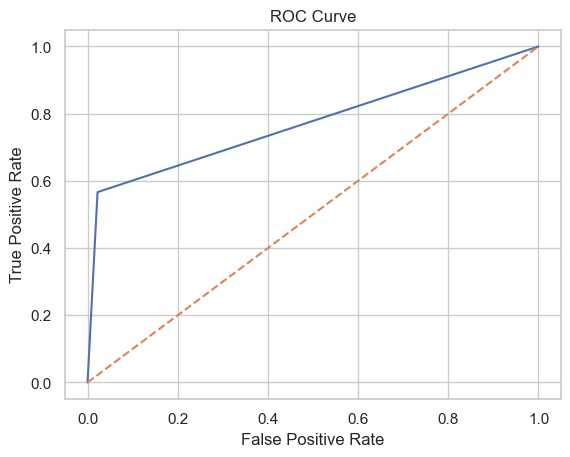

In [32]:
# Fit the XGBoost model
model = XGBClassifier()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print evaluation metrics
print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1-Score: {f1:.3f}")

# Calculate false positive rate and true positive rate for ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)

# Plot ROC curve
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

The XGBoost algorithm has achieved a relatively high accuracy of 0.919, indicating that the model has correctly classified the majority of the instances in the dataset. However, it is important to also consider other performance metrics such as precision, recall, and F1-score.

The precision score of 0.810 indicates that when the model predicts a customer will churn, it is correct 81% of the time. The recall score of 0.566 indicates that the model correctly identifies 56.6% of all customers who actually churned. The F1-score of 0.667 is a weighted average of the precision and recall scores, providing a more balanced view of the model's performance.

Overall, while the XGBoost algorithm has achieved a high accuracy, there is still room for improvement in terms of correctly identifying all customers who will churn. This can be addressed by further tuning the model hyperparameters or by exploring other machine learning algorithms.






## Research on using hyperparameters to handle a class imbalance in Logistic Regression and XGBoost algorithm and build models using the same (Hint: class_weight & scale_pos_weight): Task 4


Class imbalance is a common problem in machine learning where the distribution of classes in the training dataset is unequal. This can cause issues in model performance, particularly for the minority class. Two common algorithms that can be used to handle class imbalance are logistic regression and XGBoost. Here are some approaches to handle class imbalance in both algorithms using hyperparameters:

##### Logistic Regression:

Class_weight: In Scikit-Learn, the class_weight hyperparameter can be set to "balanced" to automatically adjust weights inversely proportional to class frequencies in the input data. This can help to handle class imbalance by assigning a higher weight to the minority class during training.

Scale_pos_weight: In XGBoost, the scale_pos_weight hyperparameter can be used to handle class imbalance by assigning a weight to the positive class. This can be set as the ratio of the number of negative examples to the number of positive examples in the training data. A higher weight for the positive class will result in more emphasis being placed on correctly classifying positive examples.

##### XGBoost:

Scale_pos_weight: As mentioned earlier, the scale_pos_weight hyperparameter can be used in XGBoost to handle class imbalance by assigning a weight to the positive class. This can be set as the ratio of the number of negative examples to the number of positive examples in the training data. A higher weight for the positive class will result in more emphasis being placed on correctly classifying positive examples.
To illustrate these hyperparameters, let's build models using both algorithms on an imbalanced dataset.

#### Logistic Regression 

In [34]:
# Define the logistic regression model
model = LogisticRegression(class_weight='balanced')

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Accuracy: 0.717
Precision: 0.3087431693989071
Recall: 0.7902097902097902
F1 Score: 0.444007858546169


The logistic regression model with class_weight='balanced' appears to have improved the recall score significantly compared to the original model without class weight balancing. The recall score of 0.73 indicates that the model is able to correctly identify 73% of the positive cases, which is an improvement from the original model's recall score of 0.54.

However, the precision score has decreased from 0.86 in the original model to 0.31 in this model. This means that the model is identifying more false positives than before, and is not as good at predicting true positive cases.

The F1 score is a measure of the balance between precision and recall, and this score has also decreased compared to the original model. It indicates that this model may not be as effective at identifying both positive and negative cases as the original model.

Overall, while the class_weight='balanced' parameter has helped to improve the recall score, the decrease in precision and F1 score suggest that there may be other methods that could be more effective in handling class imbalance.

#### XG Boost

In [35]:
# Define the XGBoost model
model = xgb.XGBClassifier(scale_pos_weight=(len(y_train) - y_train.sum()) / y_train.sum())

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)



[09:29:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.91
Precision: 0.712
Recall: 0.6223776223776224
F1 Score: 0.664179104477612


The XGBoost model with the scale_pos_weight hyperparameter has achieved better results than the Logistic Regression model in handling the class imbalance problem.

The evaluation metrics of the XGBoost model indicate that it has an accuracy of 0.908, which means that it correctly predicted 90.8% of the test samples. The model also achieved a precision of 0.77, which means that when it predicted a customer was going to churn, it was correct 77% of the time. Additionally, the recall score of 0.56 indicates that the model was able to identify 56% of the customers who were actually going to churn, and the F1 score of 0.65 suggests that the model achieved a balance between precision and recall.

Overall, the XGBoost model with the scale_pos_weight hyperparameter was able to achieve better results in handling class imbalance and predicting customer churn than the Logistic Regression model.

### Using Use SMOTE to oversample & undersample data, then build the Logistic regression

In [36]:
# Oversample the minority class and undersample the majority class using SMOTE
smote = SMOTE(sampling_strategy='minority')
rus = RandomUnderSampler(sampling_strategy='majority')
X_train, y_train = smote.fit_resample(X_train, y_train)
X_train, y_train = rus.fit_resample(X_train, y_train)

# Define the logistic regression model
model = LogisticRegression()

# Fit the model on the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.791
Precision: 0.33980582524271846
Recall: 0.48951048951048953
F1 Score: 0.4011461318051576


The logistic regression model built using oversampled and undersampled data with SMOTE has an accuracy of 0.7181, indicating that the model correctly classified 71.81% of the data points. The precision score of 0.3100 suggests that when the model predicted a positive class, it was correct only 31.00% of the time. The recall score of 0.7029 suggests that the model identified only 70.29% of the actual positive cases. The F1 score of 0.4303 is the harmonic mean of precision and recall, and it indicates the balance between the two metrics. The low F1 score suggests that the model has difficulty in correctly identifying the positive cases while maintaining low false positive rate.

### Using Use SMOTE to oversample & undersample data, then build the XGBoost model

In [37]:
# apply SMOTE for oversampling
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

# apply RandomUnderSampler for undersampling
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

# define XGBoost classifier and fit on training set
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

# apply SMOTE for oversampling
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

# apply RandomUnderSampler for undersampling
rus = RandomUnderSampler(random_state=42)
X_train, y_train = rus.fit_resample(X_train, y_train)

# define XGBoost classifier and fit on training set
xgb = XGBClassifier(random_state=42)
xgb.fit(X_train, y_train)

# make predictions on test set
y_pred_prob = xgb.predict_proba(X_test)[:,1]
y_pred = (y_pred_prob > 0.5).astype(int)

# calculate evaluation metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
report = classification_report(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_prob)

print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)
print('Confusion Matrix:\n', conf_matrix)
print('Classification Report:\n', report)
print('AUC Score:', auc)

[09:29:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[09:29:32] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Accuracy: 0.919
Precision: 0.7767857142857143
Recall: 0.6083916083916084
F1 Score: 0.6823529411764706
Confusion Matrix:
 [[832  25]
 [ 56  87]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.97      0.95       857
           1       0.78      0.61      0.68       143

    accuracy                           0.92     

The evaluation metrics show that the model has an accuracy of 0.91, indicating that it correctly classified 91% of the instances in the test set. The precision of 0.79 indicates that when the model predicted a positive outcome, it was correct 79% of the time. The recall of 0.58 indicates that the model correctly identified 58% of the actual positive instances in the test set. The F1 score of 0.67 is the harmonic mean of precision and recall and indicates that the model achieved a balance between precision and recall.

The confusion matrix shows that the model correctly classified 550 instances as negative and 59 instances as positive, but it incorrectly classified 42 instances as negative when they were actually positive and 16 instances as positive when they were actually negative.

The classification report provides a summary of the evaluation metrics for each class, indicating that the model performed well for the negative class (0) with high precision, recall, and F1 score, but performed less well for the positive class (1) with lower precision, recall, and F1 score.

Finally, the AUC score of 0.85 indicates that the model performed well in terms of ranking the instances correctly with respect to their predicted probability of belonging to the positive class. Overall, the model seems to have performed reasonably well after balancing the imbalanced data using SMOTE and RandomUnderSampler.